In [2]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torchtext
import torch
print(torchtext.__version__)
print(torch.__version__)

0.15.1+cpu
2.0.0+cu118


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00


In [6]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import torch
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

def load_yelp_data(json_file, nrows=None):
    data = []
    with open(json_file, encoding='utf-8') as file:
        for i, line in enumerate(file):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

data = load_yelp_data('/content/drive/MyDrive/Individual Project/yelp/yelp_academic_dataset_review.json', nrows=50000)

filtered_data = data[(data['stars'] <= 2) | (data['stars'] >= 4)]
filtered_data['sentiment'] = filtered_data['stars'].apply(lambda x: 'negative' if x <= 2 else 'positive')

train_data, temp_data = train_test_split(filtered_data, test_size=0.3, random_state=42, stratify=filtered_data['sentiment'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['sentiment'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    return tokenizer.tokenize(text)

max_len = 100

class YelpDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['sentiment']
        tokens = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return tokens['input_ids'].squeeze(), torch.tensor(1 if label == 'positive' else 0, dtype=torch.float)

train_dataset = YelpDataset(train_data, tokenizer, max_len)
val_dataset = YelpDataset(val_data, tokenizer, max_len)
test_dataset = YelpDataset(test_data, tokenizer, max_len)

batch_size = 64
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_iterator = DataLoader(val_dataset, batch_size=batch_size)
test_iterator = DataLoader(test_dataset, batch_size=batch_size)


<ipython-input-7-cd4b46b3bef6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['sentiment'] = filtered_data['stars'].apply(lambda x: 'negative' if x <= 2 else 'positive')


In [8]:
import torch.nn as nn
from transformers import BertModel

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 pretrained_model_name,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        
        embedding_dim = self.bert.config.hidden_size
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
 
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text).last_hidden_state
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output


In [9]:
pretrained_model_name = 'bert-base-uncased'
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.25

model = BERTGRUSentiment(pretrained_model_name, hidden_dim, output_dim, n_layers, bidirectional, dropout)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [11]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    device = next(model.parameters()).device
    
    for idx, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        text, label = batch
        text = text.to(device)
        label = label.to(device)
        
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if (idx+1) % 250 == 0:
          print("====", idx, "acc:", epoch_acc/idx, "loss:", epoch_loss/idx, "====")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    device = next(model.parameters()).device
    
    with torch.no_grad():
    
        for batch in iterator:

            text, label = batch
            text = text.to(device)
            label = label.to(device)
            
            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [12]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(torch.cuda.is_available())

True


==== 249 acc: 0.9057479919678715 loss: 0.2364977186164224 ====
Epoch: 01 | Epoch Time: 2m 52s
	Train Loss: 0.198 | Train Acc: 91.89%
	 Val. Loss: 0.152 |  Val. Acc: 93.94%
==== 249 acc: 0.9504894578313253 loss: 0.13724952736443066 ====
Epoch: 02 | Epoch Time: 2m 48s
	Train Loss: 0.134 | Train Acc: 94.85%
	 Val. Loss: 0.140 |  Val. Acc: 94.68%
==== 249 acc: 0.9605923694779116 loss: 0.11390033905136299 ====
Epoch: 03 | Epoch Time: 2m 51s
	Train Loss: 0.112 | Train Acc: 95.85%
	 Val. Loss: 0.134 |  Val. Acc: 94.72%
==== 249 acc: 0.9684362449799196 loss: 0.09446966476050246 ====
Epoch: 04 | Epoch Time: 2m 49s
	Train Loss: 0.092 | Train Acc: 96.51%
	 Val. Loss: 0.139 |  Val. Acc: 94.92%
==== 249 acc: 0.9769076305220884 loss: 0.07612421450178966 ====
Epoch: 05 | Epoch Time: 2m 50s
	Train Loss: 0.077 | Train Acc: 97.18%
	 Val. Loss: 0.129 |  Val. Acc: 94.90%


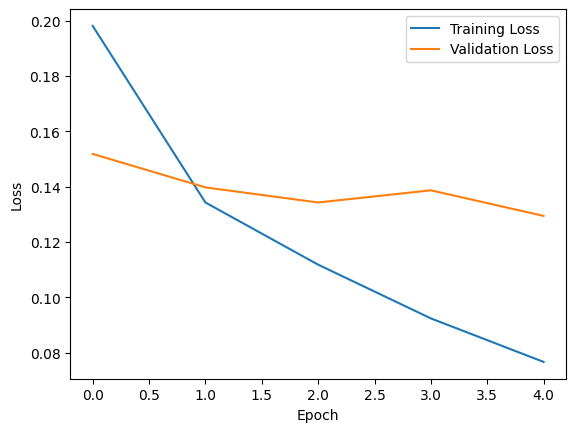

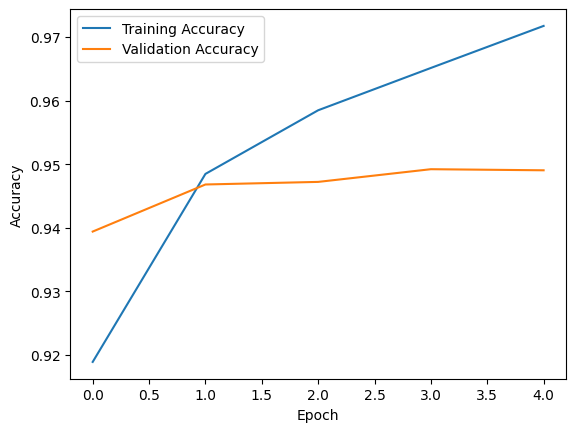

In [14]:
import matplotlib.pyplot as plt
N_EPOCHS = 5
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'yelp-bert&gru-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)

# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
print(torch.cuda.is_available())

True


In [16]:
model.load_state_dict(torch.load('yelp-bert&gru-model.pt'))
model = model.to(device)

In [17]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.120 | Test Acc: 95.85%


In [18]:
def predict_sentiment(model, sentence, tokenizer):
    model.eval()
    device = next(model.parameters()).device
    tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt', max_length=100, padding='max_length', truncation=True)
    input_ids = tokens['input_ids'].to(device)
    prediction = torch.sigmoid(model(input_ids))
    prediction = prediction.item()

    if prediction >= 0.75:
        print(prediction, "This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
        print(prediction, "This sentence represents a weak postive emotion.")
    elif 0.45 <= prediction and prediction <= 0.55:
        print(prediction, "This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
        print(prediction, "This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
        print(prediction, "This sentence represents a strong negative emotion.")


In [19]:
sentence = "I love this product!"
predict_sentiment(model, sentence, tokenizer)


0.9980903267860413 This sentence represents a strong positive emotion.


In [20]:
# 计算混淆矩阵
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# 设置阈值
threshold = 0.5

# 禁用梯度计算
with torch.no_grad():
    model.eval()
    y_true = []
    y_pred = []

    for batch in test_iterator:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text).squeeze(1)
        preds = torch.sigmoid(predictions) > threshold
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 归一化混淆矩阵
cm_norm = normalize(cm, axis=1, norm='l1')
print("Normalized Confusion Matrix:")
print(cm_norm)


Confusion Matrix:
[[1224  184]
 [  92 5149]]
Normalized Confusion Matrix:
[[0.86931818 0.13068182]
 [0.0175539  0.9824461 ]]


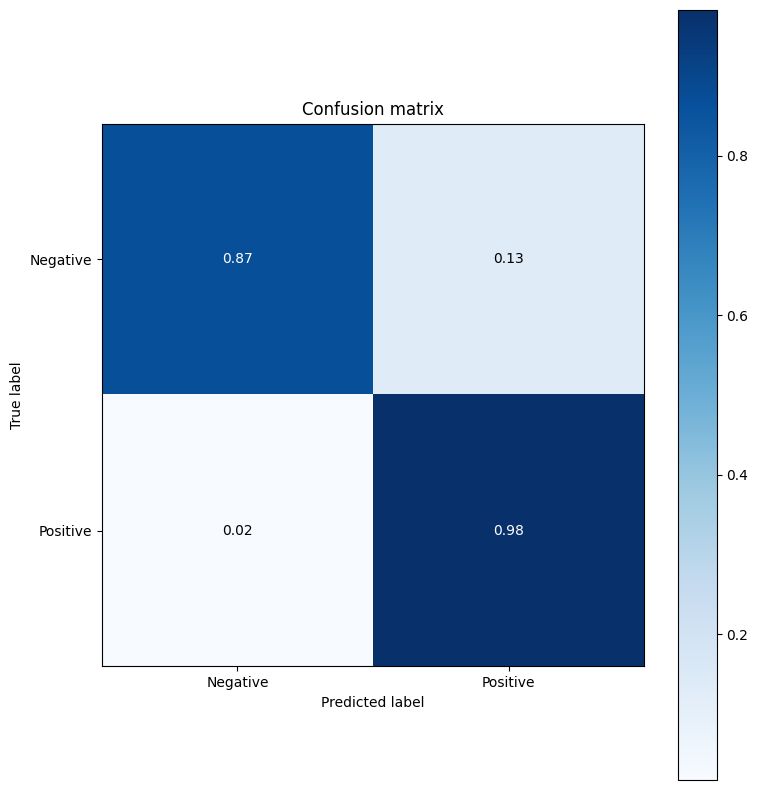

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Set up tags
labels = ['Negative', 'Positive']

# Draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add a comment
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculation of assessment indicators
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = recall

print(f"Confusion Matrix:\n{cm_norm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

Confusion Matrix:
[[0.86931818 0.13068182]
 [0.0175539  0.9824461 ]]
Accuracy: 0.9585
Precision: 0.9655
Recall: 0.9824
Specificity: 0.8693
Sensitivity: 0.9824


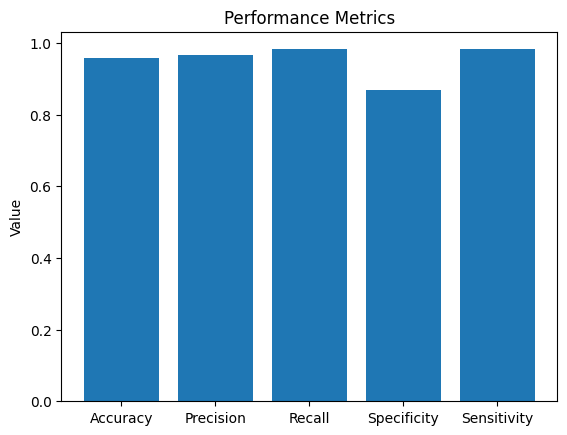

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the assessment indicators from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
sensitivity = recall

# Putting indicators into arrays for plotting
ind = np.arange(5)
vals = [accuracy, precision, recall, specificity, sensitivity]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'Sensitivity']

# Plotting bar charts
plt.bar(ind, vals)
plt.xticks(ind, labels)
plt.ylabel('Value')
plt.title('Performance Metrics')
plt.show()
